Using cache found in C:\Users\Lenovo/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-5-8 Python-3.10.0 torch-2.7.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Press SPACE to capture image.
Image captured.


C:\Users\Lenovo/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 480x640 1 dog
Speed: 138.0ms pre-process, 1328.4ms inference, 290.3ms NMS per image at shape (1, 3, 480, 640)


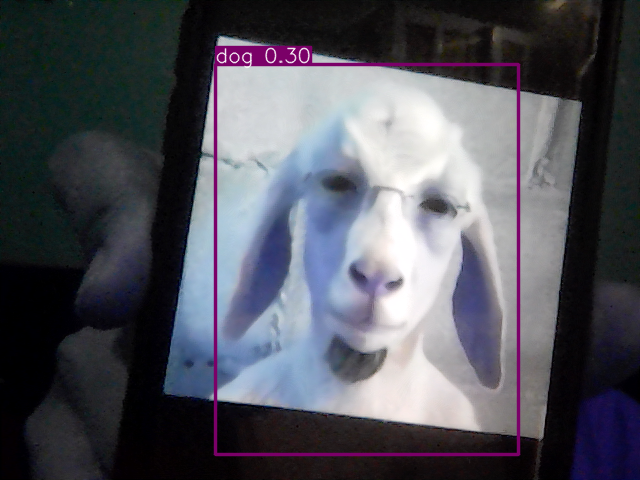

Loaded 49 faces from dataset.
Found 0 faces in the image.


In [1]:
import cv2
import torch
import face_recognition
import os
from matplotlib import pyplot as plt

# تحميل موديل YOLOv5
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# التقاط صورة من كاميرا اللابتوب
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

print("Press SPACE to capture image.")
while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame.")
        break

    cv2.imshow("Press SPACE to capture", frame)

    key = cv2.waitKey(1)
    if key % 256 == 32:  # SPACE key
        img = frame
        print("Image captured.")
        break

cap.release()
cv2.destroyAllWindows()

# كشف الأجسام باستخدام YOLO
results = model(img)
results.print()
results.show()

# تحويل الصورة إلى RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# تحميل داتا سيت الوجوه
train_path = os.path.join("dataset")
train_encodes = []
train_classes = []

for person_name in os.listdir(train_path):
    person_folder = os.path.join(train_path, person_name)

    if not os.path.isdir(person_folder):
        continue

    for image_name in os.listdir(person_folder):
        image_path = os.path.join(person_folder, image_name)
        img_person = cv2.imread(image_path)

        if img_person is None:
            continue

        img_person_rgb = cv2.cvtColor(img_person, cv2.COLOR_BGR2RGB)
        encodings = face_recognition.face_encodings(img_person_rgb)

        if encodings:
            train_encodes.append(encodings[0])
            train_classes.append(person_name)

print(f"Loaded {len(train_encodes)} faces from dataset.")

# التعرف على الوجوه في الصورة الأصلية
face_locations = face_recognition.face_locations(img_rgb, model="hog")
face_encodings = face_recognition.face_encodings(img_rgb, face_locations)

print(f"Found {len(face_encodings)} faces in the image.")

for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
    matches = face_recognition.compare_faces(train_encodes, face_encoding)
    face_name = "Unknown"

    if True in matches:
        matched_index = matches.index(True)
        face_name = train_classes[matched_index]
        print(f"Detected face: {face_name}")
    else:
        print("Detected face: Unknown")

    cv2.rectangle(img_rgb, (left, top), (right, bottom), (0, 255, 0), 2)
    cv2.putText(img_rgb, face_name, (left, bottom + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

plt.figure(figsize=(10, 8))
plt.axis("off")
plt.title("YOLO + Face Recognition")
plt.imshow(img_rgb)
plt.show()



